# Training a Rubix Cube Solver via Reinforcement Learning: Part 2

In [28]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

from lib.cube import Cube
from lib.mcts import MCTS
from lib.solver import CubeSolver
from lib.models import CNN

%matplotlib inline

## Improving solver with Monte Carlo Tree Search (MCTS)

In Solving the Rubik’s Cube Without Human Knowledge [1], the authors combine Deep Q-Learning with Monte Carlo Tree Search to achieve impressive performance with their Rubix Cube solver. This approach is adopted for this solver to improve its performance as well.

In [23]:
config = {}

config['model_params'] = {'embed_dim':100,
                          'num_filters':50,
                          'num_conv_layers':3,
                          'kernel_size':2,
                          'regularization_constant':.05,
                          'num_dense_layers':3,
                           'dense_activation':'elu',
                         'conv_activation': 'elu'}

model = CNN(**config['model_params'])
model_path = '../models/base_model_v2_20191208165135/weights'

def test_solver(solver, num_shuffles, num_trials=1000):
    num_solved = 0
    for trial in range(num_trials):
        cube = Cube()
        cube.shuffle(num_shuffles=num_shuffles,verbose=False)
        if type(solver) == MCTS:
            solved,_ = solver.solve(cube,verbose=False)
        elif type(solver) == CubeSolver:
            solved,_,_ = solver.solve(cube,max_time_steps=num_shuffles*2,verbose=False)
        if solved:
            num_solved +=1 
    solve_rate = num_solved/num_trials
    return solve_rate

greedy_solver = CubeSolver()
greedy_solver.model = model
greedy_solver.load_model_weights(model_path)

mcts_solver = MCTS(model, c=.1, v=.1, num_searches=100)
mcts_solver.load_model_weights(model_path)

([<matplotlib.axis.XTick at 0x1339b8a20>,
 <a list of 3 Text xticklabel objects>)

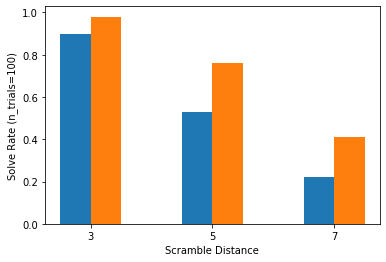

In [51]:
mcts_results = {}
greedy_results = {}
for num_shuffles in [3,5,7]:
    mcts_results[num_shuffles] = test_solver(mcts_solver,num_shuffles=num_shuffles, num_trials=100)
    greedy_results[num_shuffles] = test_solver(greedy_solver,num_shuffles=num_shuffles, num_trials=100)

# Setting the positions and width for the bars
pos = list(range(len(greedy_results))) 
width = 0.25 

plt.bar(pos, greedy_results.values(), width)
plt.bar([p + width for p in pos], mcts_results.values(), width)
plt.xlabel("Scramble Distance")
plt.ylabel("Solve Rate (n_trials=100)")
# Set the position of the x ticks
plt.xticks([p + .5 * width for p in pos], labels = list(greedy_results.keys()))


## Training with a GPU on AWS

In order to improve the performance of the Rubix Cube Solver, its neural network must be trained for a longer time and attempt to solve many more cubes. For example, the network trained in [1] is exposed to roughly ~8 billion examples of a shuffled cube. In comparison, the networks trained in part one only saw at 1000 examples of a shuffled cube. 


As it is impractical to train the solver for extended periods on my MacBook, a cloud computing solution is instead used for longer training cycles, specifically Amazon Web Services (AWS).

### Steps for training Rubix Cube Solver on AWS

#### 1) Launch an EC2 instance

        Recommended AMI: TensorFlow from NVIDIA AMI (https://aws.amazon.com/marketplace/pp/B07S2Z9N33)
        
        Recommended Instance Type: g4dn.xlarge (one of the least-expensive GPU-enabled instance types)
        
#### 2) SSH into instance 

    ssh -i <private-key.pem> ubuntu@<instance Public DNS (IPv4)>
        
#### 3) Clone repo onto EC2 instance

    git clone https://github.com/MattD18/rubix-cube.git 

#### 4) Pull Tensorflow v2.0 with GPU Docker Image

    docker pull tensorflow/tensorflow:2.0.0-gpu-py3
    
#### 5) Run training script on detached docker container

    docker run -v /home/ubuntu/:/home -d -w /home/rubix-cube/scripts --gpus all -it --rm tensorflow/tensorflow:2.0.0-gpu-py3 python train.py
    
    Note: Running the training script on a detached docker container allows the user to disconnect from their ssh session with instance during training.
    
#### 7) Set-Up AWS CLI 

    sudo apt install awscli 
    aws configure
    
#### 6) Upload results to S3 bucket from repo root directory

    ./save_results.sh


### Note on spot pricing

AWS allows users to request EC2 instances at their current "spot prices" which are often substanially cheaper than the offered "on-demand" price [2]. Spot-instances consequently provide a much more cost effective resource for training models. However, since AWS has the ability to terminate a spot instance based on current demand for the instance type, the training procedure must be fault tolerant.

For the training of the Rubix Cube solver, fault tolerance during training is done by checkpointing the networks weights every 500 epochs and saving both the checkpointed weights as well as the training logs (loss and validation accuracy) to an S3 bucket every 2 hours.
        


## Source

[1] https://arxiv.org/pdf/1805.07470.pdf

[2] https://aws.amazon.com/ec2/spot/pricing/